Seed:  4052484406
AVLTree({0.0: 0, 1.0: -1})
Clonal node: 24
Present_mutation at node:  23
HGT at Node:  16
HGT at Node:  12
HGT at Node:  9
HGT at Node:  9
HGT at Node:  6
HGT at Node:  12
HGT at Node:  9
Incoming HGT edge registered at node:  12
Incoming HGT edge registered at node:  16
[[0 1 1 0 0]]
[array([[ 0.00000000e+00,  2.06155281e+00, -2.06155281e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.22044605e-16, -2.22044605e-16,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])]
Fitch Parsimony Score: [2]


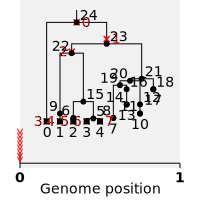

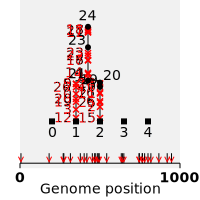

In [253]:
import msprime
import tskit
import hgt_simulation
import hgt_sim_args
import numpy as np
import random
import torch
import os
import time
import re
import secrets
import copy

from random import randint
from collections import namedtuple
from collections import defaultdict
from collections import deque
from typing import List, Union
from sbi.utils import BoxUniform

from concurrent.futures import ProcessPoolExecutor
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform


num_samples = 5
theta = 1
rho = 0.1
hgt_rate = 0.5
num_sites = 1
ce_from_nwk = None
infinite_sites_factor= 3
seed = None

nucleotide_mutation_rate = 0.01 # Rate is per position
gene_length = 1000
target_n_rows_pca = 3

core_tree = msprime.sim_ancestry(
        samples=num_samples,
        sequence_length=1,
        ploidy=1,
        recombination_rate=0,
        gene_conversion_rate=0,
        gene_conversion_tract_length=1,  # One gene
    )

ce_from_nwk = core_tree.first().newick()



start_time = time.time()

"""
if ce_from_nwk is not None and num_samples is not None:
    raise ValueError(
        "A core tree and parameters for simulation were provided. Choose either."
    )
"""
    
if ce_from_nwk is None and num_samples is None:
    raise ValueError(
        "Neither a core tree or parameters for simulation were provided. Choose either."
    )

if ce_from_nwk is None:
    core_tree = msprime.sim_ancestry(
            samples=num_samples,
            sequence_length=1,
            ploidy=1,
            recombination_rate=0,
            gene_conversion_rate=0,
            gene_conversion_tract_length=1,  # One gene
            random_seed=seed,
        )

    ce_from_nwk = core_tree.first().newick()

if seed is None:
    seed = secrets.randbelow(2**32 - 4) + 2

random.seed(seed)
np.random.seed(seed)
print("Seed: ", seed)

### Calculate hgt events:

args = hgt_sim_args.Args(
    sample_size=num_samples,
    num_sites=num_sites,
    gene_conversion_rate=0,
    recombination_rate=0,
    hgt_rate=hgt_rate,
    ce_from_ts=None,
    ce_from_nwk=ce_from_nwk,
    random_seed=seed,
    #random_seed=84,
)

ts, hgt_edges = hgt_simulation.run_simulate(args)


### Place mutations

alleles = ["absent", "present"]

# Place one mutation per site, e.g. genome position

gains_model = msprime.MatrixMutationModel(
    alleles = alleles,
    root_distribution=[1, 0],
    transition_matrix=[
        [0, 1],
        [0, 1],
    ],
)

ts_gains = msprime.sim_mutations(ts, rate=1, model = gains_model, keep = True, random_seed=seed)

k = 1
while (ts_gains.num_sites < ts_gains.sequence_length):
    ts_gains = msprime.sim_mutations(ts_gains, rate=1, model = gains_model, keep = True, random_seed=seed+k)
    k = k+1

# Remove superfluous mutations

tables = ts_gains.dump_tables()

mutations_by_site = {}
for mut in tables.mutations:
    if mut.site not in mutations_by_site:
        mutations_by_site[mut.site] = []
    mutations_by_site[mut.site].append(mut)

tables.mutations.clear()

for site, mutations in mutations_by_site.items():
    selected_mutation = random.choice(mutations)

    tables.mutations.add_row(
        site=selected_mutation.site,
        node=selected_mutation.node,
        derived_state=selected_mutation.derived_state,
        parent=-1,
        metadata=None,
        time=selected_mutation.time,
    )

    # Add sentinel mutations at the leafs:

    for leaf_position in range(num_samples):
        tables.mutations.add_row(
            site = selected_mutation.site,
            node = leaf_position,
            derived_state = "absent",
            time = 0.00000000001,
        )

ts_gains = tables.tree_sequence()


# Place losses:

losses_model = msprime.MatrixMutationModel(
    alleles = alleles,
    root_distribution=[1, 0],
    transition_matrix=[
        [1, 0],
        [1, 0],
    ],
)

ts_gains_losses = msprime.sim_mutations(ts_gains, rate = rho, model = losses_model, keep = True, random_seed=seed-1)

tables = ts_gains_losses.dump_tables()

# Find the node of the root of the clonal tree:
clonal_node = ts_gains.first().mrca(*list(range(num_samples)))

print("Clonal node:", clonal_node)

for site, mutations in mutations_by_site.items():
    # Mutation at clonal root:
    tables.mutations.add_row(
        site=site,
        node=clonal_node,
        derived_state="absent",
        parent=-1,
        metadata=None,
        time=tables.nodes.time[clonal_node],
    )

tables.sort()
ts_gains_losses = tables.tree_sequence()

### Calculate the gene absence presence matrix:

MutationRecord = namedtuple('MutationRecord', ['site_id', 'mutation_id', 'node', 'is_hgt'])

tables = ts_gains_losses.dump_tables()

tables.mutations.clear() # SIMPLE VERSION!

hgt_parent_nodes = [edge.parent-1 for edge in hgt_edges]
hgt_children_nodes = [edge.child for edge in hgt_edges]
hgt_parent_children = defaultdict(list)
hgt_parent_children_passed = [False] * ts_gains_losses.num_nodes
#hgt_children_parent = defaultdict(list)

for parent in hgt_parent_nodes:
    hgt_parent_children[parent].append(parent-1)


#for child in hgt_children_nodes:
#    hgt_children_parent[child].append(child+1)

# Initialize tables for the diversity of each gene
tables_gene = tskit.TableCollection(sequence_length=gene_length)
tables_gene.nodes.replace_with(ts_gains_losses.tables.nodes)
tables_gene.populations.replace_with(ts_gains_losses.tables.populations)

#tables_gene.mutations.clear()
#tables_gene.edges.clear()

#for i in range(num_samples):
#    tables_gene.nodes.add_row(time = 0, population = 0, flags = 1) 

tables_gene_list = [copy.deepcopy(tables_gene) for _ in range(num_sites)]
gene_trees_list = []


for tree in ts_gains_losses.trees():
    
    site = list(tree.sites())[0]
    mutations = site.mutations
    present_mutation = [m for m in mutations if m.derived_state == "present"][0]
    absent_mutations = [m for m in mutations if m.derived_state == "absent"]
    absent_mutation_nodes = {m.node for m in mutations if m.derived_state == "absent"}

    print("Present_mutation at node: ", present_mutation.node)

    branching_nodes_to_process = deque([(present_mutation.node, False, False)])
    # The second variable describes if a hgt edge was passed the whole way down to the actual node. 
    # The third describes if a hgt edge was passed in the last step.

    child_mutations = []

    if present_mutation.node < num_samples: # Gain directly above leaf:
        if present_mutation.id == sorted([mut for mut in mutations if mut.node == present_mutation.node], key=lambda m: m.time)[1].id:
            sentinel_mutation = min([mut for mut in absent_mutations if mut.node == present_mutation.node], key=lambda m: m.time)
            child_mutations.append(MutationRecord(
                site_id=site.id,
                mutation_id=sentinel_mutation.id,
                node=sentinel_mutation.node,
                is_hgt=False
            ))
            tables_gene_list[site.id].edges.add_row(
                    left = 0, right = gene_length, parent = tree.parent(present_mutation.node), child = sentinel_mutation.node
            )

    else: 
        
        # To see, which HGT edges are passed, we have to go through the tree two times. 
        # First, we detect all passed HGT edges, then we calculate the presence of mutations in the leaves.

        # First time going through:
        while branching_nodes_to_process:
            
            last_branching_node = branching_nodes_to_process.popleft()
            selected_branch_nodes_to_process = deque([last_branching_node])
            
            while selected_branch_nodes_to_process:
            
                child_node = selected_branch_nodes_to_process.popleft()    
    
                # If there is a mutation on the edge, find the earliest one.
                if not child_node[2] and child_node[0] in absent_mutation_nodes:
                    
                    absent_mutation_after_gain_at_node = [mut for mut in absent_mutations if mut.node == child_node[0] and mut.time < present_mutation.time]
                    
                    if not absent_mutation_after_gain_at_node: # empty
                        children = tree.children(child_node[0])
                        if len(children) > 1:
                            for child in reversed(children):
                                branching_nodes_to_process.extendleft([(child, child_node[1], False)])
                        else:
                            for child in reversed(children):
                                selected_branch_nodes_to_process.extendleft([(child, child_node[1], False)])
                        if hgt_parent_children[child_node[0]]:
                            selected_branch_nodes_to_process.extendleft([(hgt_parent_children[child_node[0]][0], True, True)])
                            hgt_parent_children_passed[hgt_parent_children[child_node[0]][0]] = True # The child of the hgt_edge is marked
                            print("HGT at Node: ", hgt_parent_children[child_node[0]][0])
                        
        
                # If there is no mutation, add child nodes.
                else:
                    children = tree.children(child_node[0])
                    if len(children) > 1:
                        for child in reversed(children):
                            branching_nodes_to_process.extendleft([(child, child_node[1], False)])
                    else:
                        for child in reversed(children):
                            selected_branch_nodes_to_process.extendleft([(child, child_node[1], False)])
                    if hgt_parent_children[child_node[0]]:
                        selected_branch_nodes_to_process.extendleft([(hgt_parent_children[child_node[0]][0], True, True)])
                        hgt_parent_children_passed[hgt_parent_children[child_node[0]][0]] = True # The child of the hgt_edge is marked
                        print("HGT at Node: ", hgt_parent_children[child_node[0]][0])

        # Second time going through:
        
        branching_nodes_to_process = deque([(present_mutation.node, False, False)])
        
        while branching_nodes_to_process:
            
            last_branching_node = branching_nodes_to_process.popleft()
            selected_branch_nodes_to_process = deque([last_branching_node])
            
            while selected_branch_nodes_to_process:
            
                child_node = selected_branch_nodes_to_process.popleft()

                if not child_node[2] and hgt_parent_children_passed[child_node[0]]:
                    print("Incoming HGT edge registered at node: ", child_node[0])
                    continue
    
                # If there is a mutation on the edge, find the earliest one.
                if not child_node[2] and child_node[0] in absent_mutation_nodes:
                    
                    absent_mutation_after_gain_at_node = [mut for mut in absent_mutations if mut.node == child_node[0] and mut.time < present_mutation.time]
                    
                    if absent_mutation_after_gain_at_node: # not empty
                        earliest_mutation = max(
                            [mut for mut in absent_mutations if mut.node == child_node[0] and mut.time < present_mutation.time], 
                            key=lambda m: m.time
                        )
        
                        if earliest_mutation.time == 0.00000000001:
                            earliest_mutation.derived_state = "present"
                            child_mutations.append(MutationRecord(
                                site_id=site.id,
                                mutation_id=earliest_mutation.id,
                                node=earliest_mutation.node,
                                is_hgt=child_node[1]
                            ))
                            tables_gene_list[site.id].edges.add_row(
                                left = 0, right = gene_length, parent = tree.parent(last_branching_node[0]), child = earliest_mutation.node
                            )
                    else:
                        children = tree.children(child_node[0])
                        if len(children) > 1:
                            for child in reversed(children):
                                branching_nodes_to_process.extendleft([(child, child_node[1], False)])
                            tables_gene_list[site.id].edges.add_row(
                                    left = 0, right = gene_length, parent = tree.parent(last_branching_node[0]), child = child_node[0]
                            )
                        else:
                            for child in reversed(children):
                                selected_branch_nodes_to_process.extendleft([(child, child_node[1], False)])
                        if hgt_parent_children[child_node[0]]:
                            selected_branch_nodes_to_process.extendleft([(hgt_parent_children[child_node[0]][0], True, True)])  
                        
        
                # If there is no mutation, add child nodes.
                else:
                    children = tree.children(child_node[0])
                    if len(children) > 1:
                        for child in reversed(children):
                            branching_nodes_to_process.extendleft([(child, child_node[1], False)])
                        tables_gene_list[site.id].edges.add_row(
                                left = 0, right = gene_length, parent = tree.parent(last_branching_node[0]), child = child_node[0]
                        )
                    else:
                        for child in reversed(children):
                            selected_branch_nodes_to_process.extendleft([(child, child_node[1], False)])
                    if hgt_parent_children[child_node[0]]:
                        selected_branch_nodes_to_process.extendleft([(hgt_parent_children[child_node[0]][0], True, True)])

    child_mutations.sort(key=lambda mut: not mut.is_hgt) # Will set is_hgt to False later if there are paths without hgt events to the leaf.

    # We have to adress multiple paths to the same destiny, some with hgt and other without it:
    unique_mutations = {}

    for mut in child_mutations:
        if mut.node not in unique_mutations:
            unique_mutations[mut.node] = mut
        else:
            existing_mut = unique_mutations[mut.node]
            if not existing_mut.is_hgt or not mut.is_hgt:
                unique_mutations[mut.node] = mut._replace(is_hgt=False)
    
    child_mutations_filtered = list(unique_mutations.values())

    for mutation in mutations:
        if mutation.time > 0.00000000001:
            if mutation.derived_state == "absent":
                metadata_value = bytes([3]) 
            elif mutation.derived_state == "present":
                metadata_value = bytes([7])
            tables.mutations.add_row(
                site=site.id,
                node=mutation.node,
                derived_state=mutation.derived_state,
                parent=-1,
                metadata=metadata_value,
                time=mutation.time,
            )
    
    for mutation in child_mutations_filtered:

        #tables.mutations[mutation.mutation_id] = tables.mutations[mutation.mutation_id].replace(derived_state = "present", metadata = bytes([mutation.is_hgt]))

        tables.mutations.add_row(
            site=site.id,
            node=mutation.node,
            derived_state="present",
            parent=-1,
            metadata=bytes([mutation.is_hgt]),
            time=0.00000000001,
        )

mts = tables.tree_sequence()


# For each gene, there can only be one edge that ends in the same child. Choose one path randomly and remove the others which occured due to hgt.
for i in range(num_sites):

    """
    child_to_edges = dict()
    
    for edge in tables_gene_list[i].edges:
        edge_tuple = (edge.left, edge.right, edge.parent, edge.child)
        child_to_edges.setdefault(edge.child, []).append(edge_tuple)

    selected_edges = []
    for edges in child_to_edges.values():
        selected_edges.append(random.choice(edges))

    tables_gene_list[i].edges.clear()
    for edge in selected_edges:
        tables_gene_list[i].edges.add_row(*edge)

    """

    tables_gene_list[i].sort()

    gene_trees_list.append(tables_gene_list[i].tree_sequence())



# Simulate the tree for each gene:


nucleotide_mutation = msprime.MatrixMutationModel(
        alleles=["C", "M1", "M2", "M3"],
        root_distribution=[1.0, 0.0, 0.0, 0.0],  # nur C als Wurzel
        transition_matrix=[
            # C     M1     M2     M3
            [ 0.0,  1/3,  1/3,  1/3 ], 
            [ 1/3,  0,    1/3,  1/3 ],  
            [ 1/3,  1/3,  0.0,  1/3 ],  
            [ 1/3,  1/3,  1/3,  0.0 ],  
        ]
    )

"""
nucleotide_mutation = msprime.InfiniteAlleles()
"""

for i in range(num_sites):   
    gene_trees_list[i] = msprime.sim_mutations(gene_trees_list[i], rate = nucleotide_mutation_rate, model = nucleotide_mutation, keep = True, random_seed=seed-1)

# Calculate the different alleles:

alleles_list = []

for i in range(num_sites):
    alleles_list.append([])
    for var in gene_trees_list[i].variants():
        alleles_list[i].append(var.genotypes)
    alleles_list[i] = np.array(alleles_list[i])


# Perform a PCA to reduce the number of dimensions while keeping the same distances:

alleles_list_pca = []

for A in alleles_list:
    A = A.astype(float)
    
    if A.shape[0] == 0:
        A_reconstructed = np.full((target_n_rows_pca, num_samples), 0.0)
        alleles_list_pca.append(A_reconstructed)
        continue
    
    # Spalten finden, die nur -1 enthalten
    cols_all_minus1 = (A[0] == -1)
    valid_cols = ~cols_all_minus1
    
    # Falls alle Spalten -1 sind (also keine gültigen Spalten)
    if valid_cols.sum() == 0:
        alleles_list_pca.append(np.full((target_n_rows_pca, A.shape[1]), -1))
        continue
    # Sonderfall: Nur eine gültige Spalte → kein SVD möglich
    if valid_cols.sum() == 1:
        valid_index = np.where(valid_cols)[0][0]
        A_valid = A[0, valid_index]  # nur erste Zeile, einzelner Wert
        A_final = np.full((target_n_rows_pca, A.shape[1]), -1)
        A_final[:, valid_index] = A_valid  # kopiert den Wert in alle Zeilen
        alleles_list_pca.append(A_final)
        continue
    
    # PCA auf nur gültige Spalten
    A_valid = A[:, valid_cols]
    
    # Add rows of zeros if there are not enough valid rows:
    n_rows = A_valid.shape[0]
    if n_rows < target_n_rows_pca:
        pad_rows = target_n_rows_pca - n_rows
        A_valid = np.vstack([A_valid, np.zeros((pad_rows, A_valid.shape[1]))])
    
    # Anzahl Komponenten begrenzen auf gültige Dimensionen
    n_components = min(target_n_rows_pca, A_valid.shape[1], A_valid.shape[0])
    
    # PCA auf A_valid.T (also Spalten als Samples)
    pca = PCA(n_components=n_components)
    A_pca = pca.fit_transform(A_valid.T).T

    if A_pca.shape[0] < target_n_rows_pca: # Fill the bottom with zeros if neccessary to always get the same dimension
        A_pca = np.vstack([A_pca, np.zeros((target_n_rows_pca - A_pca.shape[0], A_pca.shape[1]))])

    A_reconstructed = np.full((target_n_rows_pca, A.shape[1]), 0.0)
    A_reconstructed[:, valid_cols] = A_pca
    
    #print(squareform(pdist(A_valid.T, metric='euclidean')))
    #print(squareform(pdist(A_pca.T, metric='euclidean')))

    alleles_list_pca.append(A_reconstructed)





### Print the computation time.

#print(f"Success: hgt_rate = {hgt_rate}, Total computation time = {elapsed_time:.6f} seconds.")

#for i in range(num_sites):
#    print(tables_gene_list[i].edges)

tables_gene_list[0].edges

#print(gene_trees_list[0].tables.mutations)

gene_absence_presence_matrix = []

for var in mts.variants():
    gene_absence_presence_matrix.append(var.genotypes)
gene_absence_presence_matrix = np.array(gene_absence_presence_matrix)

print(gene_absence_presence_matrix)

print(alleles_list_pca)

# Score berechnen
score = fitch_parsimony_score(ts_gains_losses, gene_absence_presence_matrix)
print(f"Fitch Parsimony Score: {score}")

from IPython.display import SVG, display
if gene_trees_list[0].num_edges:
    display(ts_gains_losses.draw_svg())
    display(SVG(gene_trees_list[0].draw_svg()))
else:
    print("Leere TreeSequence – nichts zu plotten.")


In [241]:
tree = ts_gains_losses.first()
print(tree.draw_text())


                     52                 
          ┏━━━━━━━━━━━┻━━━━━━━━━━━━┓    
         51                        ┃    
    ┏━━━━━┻━━━━┓                   ┃    
    ┃          ┃                  50    
    ┃          ┃               ┏━━━┻━━━┓
   49          ┃               ┃       ┃
 ┏━━┻━━━┓      ┃               ┃       ┃
 ┃      ┃     48               ┃       ┃
 ┃      ┃      ┃               ┃       ┃
 ┃     46     47               ┃       ┃
 ┃      ┃                      ┃       ┃
 ┃      ┃                      ┃      45
 ┃      ┃                      ┃       ┃
 ┃      ┃                     43      44
 ┃      ┃                      ┃        
 ┃      ┃                     42        
 ┃      ┃                 ┏━━━━┻━━━━┓   
 ┃      ┃                 ┃        41   
 ┃      ┃                 ┃         ┃   
 ┃      ┃                39        40   
 ┃      ┃                 ┃             
 ┃      ┃                38             
 ┃      ┃             ┏━━━┻━━━┓         
 ┃      ┃       

Fitch Parsimony Score: [0]


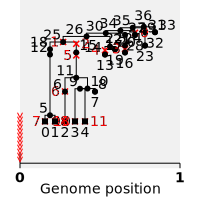

In [233]:
import numpy as np
import tskit

def fitch_parsimony_score(tree_sequence: tskit.trees.TreeSequence, genotypes: np.ndarray) -> int:
    """
    Berechnet den Fitch-Parsimony-Score für einen einzelnen tskit.Tree
    und einen Vektor von binären Genotypen (0/1) für jeden Leaf-Node.
    
    Parameter:
    - tree: tskit.Tree Objekt
    - genotypes: np.ndarray der Länge tree.num_samples (z. B. 0 = Gen fehlt, 1 = Gen vorhanden)
    
    Rückgabe:
    - parsimony_score: minimale Anzahl der Zustandsänderungen im Baum
    """

    scores = list()
    site_id = 0
    
    if len(genotypes) > 0:
        num_samples = len(genotypes[0])
    else:
        raise ValueError("Empty genotypes matrix")
    
    for tree in tree_sequence.trees():
        # Map: node -> Menge möglicher Zustände (initial nur Blätter gesetzt)
        states = {}
    
        # Bottom-up Traversierung (Postorder)
        score = 0
        for node in tree.postorder():
            if node < num_samples and tree.is_leaf(node):
                # Zustand des Blattes
                g = genotypes[site_id][node]
                states[node] = {g}
            elif tree.is_leaf(node):
                states[node] = {0,1}
            else:
                # Hole Zustände der Kinder
                child_states = [states[child] for child in tree.children(node)]
    
                # Schnittmenge berechnen
                intersection = child_states[0].intersection(*child_states[1:])
                if intersection:
                    states[node] = intersection
                else:
                    # Kein gemeinsamer Zustand → Score +1, Union verwenden
                    union = set.union(*child_states)
                    states[node] = union
                    score += 1
                
        scores.append(score)
        
        site_id += 1

    return scores

import numpy as np


# Score berechnen
score = fitch_parsimony_score(ts_gains_losses, gene_absence_presence_matrix)
print(f"Fitch Parsimony Score: {score}")

ts_gains_losses.draw_svg()

In [211]:
gene_absence_presence_matrix = []

for var in mts.variants():
    gene_absence_presence_matrix.append(var.genotypes)
gene_absence_presence_matrix = np.array(gene_absence_presence_matrix)

print(gene_absence_presence_matrix)

[[0 0 0 0 1]]


[4]
[[0 0 0 0 0]]


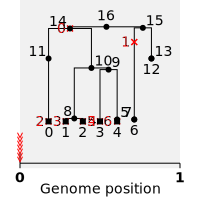

In [190]:
# ALT

def compute_fitch_scores(ts_gains_losses, gene_absence_presence_matrix):
    
    fitch_scores = []

    for site_index, genotypes in enumerate(gene_absence_presence_matrix):
        tree = ts_gains_losses.at(site_index) if ts_gains_losses.num_trees > 1 else ts_gains_losses.first()
        states = {}
        score = 0

        # sichere Zuordnung: nur gültige Samples mit Genotyp
        sample_genotypes = {}
        for i, node in enumerate(tree.samples()):
            sample_genotypes[node] = genotypes[i]

        def fitch(node):
            nonlocal score

            if node in sample_genotypes:
                states[node] = {sample_genotypes[node]}
                return states[node]
            
            child_states = [fitch(child) for child in tree.children(node)]
            
            if not child_states:
                states[node] = set()
                return states[node]
            
            intersection = child_states[0].intersection(*child_states[1:])
            
            if intersection:
                states[node] = intersection
            else:
                states[node] = set.union(*child_states)
                score += 1

            return states[node]

        fitch(tree.root)
        fitch_scores.append(score)

    return fitch_scores


gene_absence_presence_matrix = []

for var in ts_gains_losses.variants():
    gene_absence_presence_matrix.append(var.genotypes)

gene_absence_presence_matrix = np.array(gene_absence_presence_matrix)

scores = compute_fitch_scores(ts_gains_losses, gene_absence_presence_matrix)
print(scores)

print(gene_absence_presence_matrix)
ts_gains_losses.draw_svg()

In [128]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import numpy as np

target_n_rows_pca = 3
#def reduce_alleles_pca(alleles_list, target_n_rows_pca):
alleles_list_pca = []

for A in alleles_list:
    A = A.astype(float)
    
    if A.shape[0] == 0:
        A_reconstructed = np.full((target_n_rows_pca, num_samples), 0.0)
        alleles_list_pca.append(A_reconstructed)
        continue
    
    # Spalten finden, die nur -1 enthalten
    cols_all_minus1 = (A[0] == -1)
    valid_cols = ~cols_all_minus1
    
    # Falls alle Spalten -1 sind (also keine gültigen Spalten)
    if valid_cols.sum() == 0:
        # komplette Matrix aus -1, gib -1-Matrix mit target_n_rows_pca zurück
        alleles_list_pca.append(np.full((target_n_rows_pca, A.shape[1]), -1))
        continue
    # Sonderfall: Nur eine gültige Spalte → kein SVD möglich
    if valid_cols.sum() == 1:
        valid_index = np.where(valid_cols)[0][0]
        A_valid = A[0, valid_index]  # nur erste Zeile, einzelner Wert
        A_final = np.full((target_n_rows_pca, A.shape[1]), -1)
        A_final[:, valid_index] = A_valid  # kopiert den Wert in alle Zeilen
        alleles_list_pca.append(A_final)
        continue
    
    # PCA auf nur gültige Spalten
    A_valid = A[:, valid_cols]
    # Imputation nicht nötig, da alle Werte in gültigen Spalten nicht -1 sind
    
    # Pad falls nötig
    n_rows = A_valid.shape[0]
    if n_rows < target_n_rows_pca:
        pad_rows = target_n_rows_pca - n_rows
        A_valid = np.vstack([A_valid, np.zeros((pad_rows, A_valid.shape[1]))])
    
    # Anzahl Komponenten begrenzen auf gültige Dimensionen
    n_components = min(target_n_rows_pca, A_valid.shape[1], A_valid.shape[0])
    
    # PCA auf A_valid.T (also Spalten als Samples)
    pca = PCA(n_components=n_components)
    # Transponieren, damit Spalten zu Samples werden
    A_pca = pca.fit_transform(A_valid.T).T  # shape: (n_valid_cols, n_components)

    if A_pca.shape[0] < target_n_rows_pca: # Fill the bottom with zeros if neccessary to always get the same dimension
        A_pca = np.vstack([A_pca, np.zeros((target_n_rows_pca - A_pca.shape[0], A_pca.shape[1]))])

    A_reconstructed = np.full((target_n_rows_pca, A.shape[1]), 0.0)
    A_reconstructed[:, valid_cols] = A_pca
    print(squareform(pdist(A_valid.T, metric='euclidean')))
    print(squareform(pdist(A_pca.T, metric='euclidean')))
    # Optional: Erzeuge zurücktransformierte Spalten (approximation)
    #A_approx = pca.inverse_transform(A_pca.T)  # shape: (n_valid_cols, n_valid_cols)

    alleles_list_pca.append(A_reconstructed)

#    return alleles_list_pca

#reduced = reduce_alleles_pca(alleles_list, target_n_rows_pca=3)

print(alleles_list[0].shape)
print(alleles_list_pca[0].shape)

(4, 5)
(3, 5)


In [107]:
ts_gains_losses.num_nodes

272

In [58]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans

def reduce_rows_preserve_columns(alleles_list, target_n_rows_pca):
    alleles_list_pca = []

    for A in alleles_list:
        A = np.array(A)
        # Spalten mit nur -1 erkennen
        minus1_cols = (A[0] == -1)
        A_valid = A[:, ~minus1_cols]

        # Falls nicht genug Zeilen da sind
        if A_valid.shape[0] <= target_n_rows_pca:
            A_padded = np.full((target_n_rows_pca, A.shape[1]), -1)
            A_padded[:A.shape[0], :] = A
            alleles_list_pca.append(A_padded)
            continue

        # Clustern
        kmeans = MiniBatchKMeans(n_clusters=target_n_rows_pca, random_state=0, batch_size=100)
        kmeans.fit(A_valid)

        # Für jeden Cluster das nächstgelegene Originalbeispiel wählen
        representatives = []
        for center in kmeans.cluster_centers_:
            dists = np.linalg.norm(A_valid - center, axis=1)
            idx = np.argmin(dists)
            representatives.append(A[idx])

        A_reduced = np.vstack(representatives)

        # Sicherheitscheck falls Reihenfolge dupliziert wurde
        if A_reduced.shape[0] < target_n_rows_pca:
            padding = np.full((target_n_rows_pca - A_reduced.shape[0], A.shape[1]), -1)
            A_reduced = np.vstack([A_reduced, padding])

        alleles_list_pca.append(A_reduced)

    return alleles_list_pca

reduced = reduce_alleles_pca(alleles_list, target_n_rows_pca=3)

print(alleles_list)
print(reduced)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]]
[[-7.07106781e-01  7.85046229e-17]
 [ 7.07106781e-01  7.85046229e-17]]
[array([[ 1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1]]), array([[-1, -1, -1,  1,  1],
       [-1, -1, -1,  1,  1],
       [-1, -1, -1,  1,  1],
       [-1, -1, -1,  1,  1],
       [-1, -1, -1,  1,  1],
       [-1, -1, -1,  0,  1],
       [-1, -1, -1,  1,  1],
       [-1, -1, -1,  0,  1],
       [-1, -1, -1,  1,  1],
       [-1, -1, -1,  1,  1]]), array([[-1, -1,  1, -1, -1],
       [-1, -1,  1, -1, -1],
       [-1, -1,  1, -1, -1],
       [-1, -1,  1, -1, -1],
       [-1, -1,  1, -1, -1],
       [-1, -1,  1, -1, -1],
       [-1, -1,  1, -1, -1],
       [-1, -1,  1, -1, -1],
       [-1, -1,  1, -1, -1],
       [-1, -1,  1, -1, -1],
       [-1, -1,  1, -1, -1]])]
[array([[ 1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1],
       [ 1, -1, -1

In [162]:
def calculate_mutations_in_leafs(mts, hgt_edges):
    
    MutationRecord = namedtuple('MutationRecord', ['site_id', 'mutation_id', 'node', 'is_hgt'])
    
    tables = mts.dump_tables()
    
    tables.mutations.clear() # SIMPLE VERSION!
    
    hgt_parent_nodes = [edge.parent-1 for edge in hgt_edges]
    hgt_parent_children = defaultdict(list)
        
    for parent in hgt_parent_nodes:
        hgt_parent_children[parent].append(parent-1)
            
    for tree in mts.trees():
        
        for site in tree.sites():
            mutations = site.mutations
            present_mutation = [m for m in mutations if m.derived_state == "present"][0]
            absent_mutations = [m for m in mutations if m.derived_state == "absent"]
            absent_mutation_nodes = {m.node for m in mutations if m.derived_state == "absent"}
    
            nodes_to_process = deque([(present_mutation.node, False, False)])
            # The second variable describes if a hgt edge has passed in the whole way down to the actual node. 
            # The third describes if a hgt edge was passed in the last step.
    
            child_mutations = []
            
            #visited = set()  # Prevents duplicate processing of nodes.
    
            if present_mutation.node < num_samples: # Gain directly above leaf:
                if present_mutation.id == sorted([mut for mut in mutations if mut.node == present_mutation.node], key=lambda m: m.time)[1].id:
                    sentinel_mutation = min([mut for mut in absent_mutations if mut.node == present_mutation.node], key=lambda m: m.time)
                    child_mutations.append(MutationRecord(
                        site_id=site.id,
                        mutation_id=sentinel_mutation.id,
                        node=sentinel_mutation.node,
                        is_hgt=False
                    ))
    
            else:
                while nodes_to_process:
                    #print(nodes_to_process)
                    child_node = nodes_to_process.popleft()
    
                    """
                    # Process the node only if it has not been visited yet.
                    if child_node in visited:
                        continue
                    visited.add(child_node)
                    """
        
                    # If there is a mutation on the edge, find the earliest one.
                    if not child_node[2] and child_node[0] in absent_mutation_nodes:
                        
                        absent_mutation_after_gain_at_node = [mut for mut in absent_mutations if mut.node == child_node[0] and mut.time < present_mutation.time]
                        
                        if absent_mutation_after_gain_at_node: # not empty
                            earliest_mutation = max(
                                [mut for mut in absent_mutations if mut.node == child_node[0] and mut.time < present_mutation.time], 
                                key=lambda m: m.time
                            )
            
                            if earliest_mutation.time == 0.00000000001:
                                earliest_mutation.derived_state = "present"
                                child_mutations.append(MutationRecord(
                                    site_id=site.id,
                                    mutation_id=earliest_mutation.id,
                                    node=earliest_mutation.node,
                                    is_hgt=child_node[1]
                                ))
                        else:
                            for child in tree.children(child_node[0]):
                                nodes_to_process.extend([(child, child_node[1], False)])
                            if hgt_parent_children[child_node[0]]:
                                nodes_to_process.extend([(hgt_parent_children[child_node[0]][0], True, True)])  
                            
            
                    # If there is no mutation, add child nodes.
                    else:
                        for child in tree.children(child_node[0]):
                            nodes_to_process.extend([(child, child_node[1], False)])
                        if hgt_parent_children[child_node[0]]:
                            nodes_to_process.extend([(hgt_parent_children[child_node[0]][0], True, True)])
    
            child_mutations.sort(key=lambda mut: not mut.is_hgt) # Will set is_hgt to False later if there are paths without hgt events to the leaf.
    
            # We have to adress multiple paths to the same destiny, some with hgt and other without it:
            unique_mutations = {}
    
            for mut in child_mutations:
                if mut.node not in unique_mutations:
                    unique_mutations[mut.node] = mut
                else:
                    existing_mut = unique_mutations[mut.node]
                    if not existing_mut.is_hgt or not mut.is_hgt:
                        unique_mutations[mut.node] = mut._replace(is_hgt=False)
            
            child_mutations_filtered = list(unique_mutations.values())
    
            for mutation in mutations:
                if mutation.time > 0.00000000001:
                    if mutation.derived_state == "absent":
                        metadata_value = bytes([3]) 
                    elif mutation.derived_state == "present":
                        metadata_value = bytes([7])
                    tables.mutations.add_row(
                        site=site.id,
                        node=mutation.node,
                        derived_state=mutation.derived_state,
                        parent=-1,
                        metadata=metadata_value,
                        time=mutation.time,
                    )
            
            for mutation in child_mutations_filtered:
    
                #tables.mutations[mutation.mutation_id] = tables.mutations[mutation.mutation_id].replace(derived_state = "present", metadata = bytes([mutation.is_hgt]))
    
                tables.mutations.add_row(
                    site=site.id,
                    node=mutation.node,
                    derived_state="present",
                    parent=-1,
                    metadata=bytes([mutation.is_hgt]),
                    time=0.00000000001,
                )
    
    mts = tables.tree_sequence()

    return mts

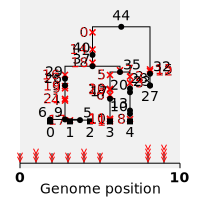

In [98]:
gene_mutation_rate = 1

def tree_sequence_from_site_preserve_ids(mts, site_id, gene_length=1.0):
    site = mts.site(site_id)
    hgt_edges_leaf = [edge for edge in hgt_edges if edge.left <= site < edge.right]
    
    
    position = site.position
    tree = mts.at(position)
    
    tables = tskit.TableCollection(sequence_length=gene_length)
    
    tables.populations.replace_with(mts.tables.populations)
    tables.nodes.replace_with(mts.tables.nodes)
    
    # Kanten für den Baum an dieser Site übernehmen
    for child in tree.nodes():
        parent = tree.parent(child)
        if parent != tskit.NULL:
            tables.edges.add_row(
                left=0.0,
                right=gene_length,
                parent=parent,
                child=child
            )
    
    tables.sort()

    mts_site = tables.tree_sequence()

    losses_model = msprime.MatrixMutationModel(
        alleles=["C", "M1", "M2", "M3"],
        root_distribution=[1.0, 0.0, 0.0, 0.0],  # nur C als Wurzel
        transition_matrix=[
            # C     M1     M2     M3
            [ 0.0,  1/3,  1/3,  1/3 ], 
            [ 1/3,  0,    1/3,  1/3 ],  
            [ 1/3,  1/3,  0.0,  1/3 ],  
            [ 1/3,  1/3,  1/3,  0.0 ],  
        ]
    )
    
    mts_site = msprime.sim_mutations(mts_site, rate = gene_mutation_rate, model = losses_model, keep = True, random_seed=seed-1)

    mts_site = calculate_mutations_in_leafs(mts_site, hgt_edges_leaf)

    return mts_site

sitewise_ts_list = []

for site_id in range(mts.num_sites):
    ts_i = tree_sequence_from_site_preserve_ids(mts, site_id, gene_length=10)
    sitewise_ts_list.append(ts_i)



sitewise_ts_list[4].draw_svg()

In [101]:
sitewise_ts_list[4].tables.mutations

gene_absence_presence_matrix = []

for var in sitewise_ts_list[4].sites():
    gene_absence_presence_matrix.append(var.genotypes)
gene_absence_presence_matrix = np.array(gene_absence_presence_matrix)

gene_absence_presence_matrix

AttributeError: 'Site' object has no attribute 'genotypes'

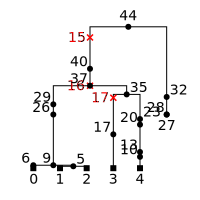

In [76]:
mts.at(4).draw_svg()

In [108]:
site = 7

print(hgt_edges)

hgt_edges_leaf = [edge for edge in hgt_edges if edge.left <= site < edge.right]

print(hgt_edges_leaf)

[Edge(left=7, right=8, parent=8, child=6, metadata=b'\x02', id=None), Edge(left=9, right=10, parent=12, child=10, metadata=b'\x02', id=None), Edge(left=9, right=10, parent=15, child=13, metadata=b'\x02', id=None), Edge(left=6, right=7, parent=19, child=17, metadata=b'\x02', id=None), Edge(left=7, right=8, parent=22, child=20, metadata=b'\x02', id=None), Edge(left=6, right=7, parent=25, child=23, metadata=b'\x02', id=None), Edge(left=4, right=5, parent=28, child=26, metadata=b'\x02', id=None), Edge(left=6, right=7, parent=31, child=29, metadata=b'\x02', id=None), Edge(left=9, right=10, parent=34, child=32, metadata=b'\x02', id=None), Edge(left=9, right=10, parent=42, child=40, metadata=b'\x02', id=None)]
[Edge(left=7, right=8, parent=8, child=6, metadata=b'\x02', id=None), Edge(left=7, right=8, parent=22, child=20, metadata=b'\x02', id=None)]


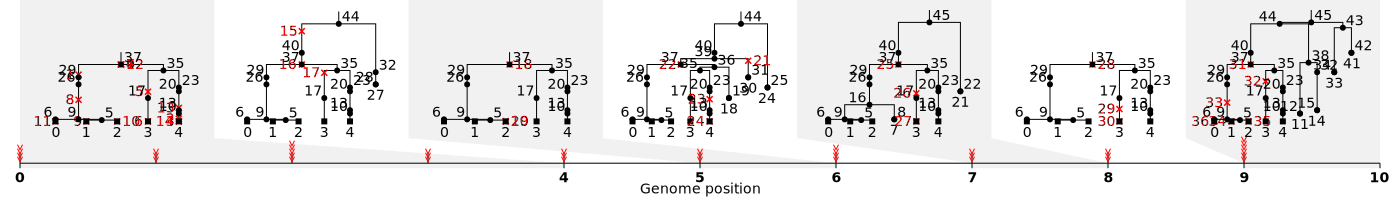

In [109]:
mts.draw_svg()